In [1]:
!pip install --upgrade openai



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from openai import OpenAI

sns.set(style="whitegrid")

# OpenAI client
client = OpenAI(api_key="skxxxx")

In [3]:
input_file = "SA - Data for Task 1.xlsx"
df = pd.read_excel(input_file)

print("Data Loaded:", df.shape)


Data Loaded: (100, 52)


In [4]:
summary = []

for col in df.columns:
    col_data = df[col]

    col_summary = {
        "Column": col,
        "Data Type": str(col_data.dtype),
        "Non-Null Count": col_data.notna().sum(),
        "Missing Count": col_data.isna().sum(),
        "Missing %": round(col_data.isna().mean() * 100, 2),
        "Unique Values": col_data.nunique(dropna=True),
        "Sample Values": col_data.dropna().unique()[:5]
    }

    if np.issubdtype(col_data.dtype, np.number):
        col_summary.update({
            "Mean": col_data.mean(),
            "Std": col_data.std(),
            "Min": col_data.min(),
            "Max": col_data.max()
        })
    else:
        col_summary.update({
            "Mean": None, "Std": None, "Min": None, "Max": None
        })

    summary.append(col_summary)

summary_df = pd.DataFrame(summary)


In [5]:
df_clean = df.copy()

# Replace invalid tokens
invalid_tokens = ["N/A", "NA", "?", "Unknown", "unknown", "", " "]

for col in df_clean.select_dtypes(include="object"):
    df_clean[col] = df_clean[col].replace(invalid_tokens, np.nan)

# Drop columns with >80% missing
missing_pct = df_clean.isna().mean() * 100
df_clean.drop(columns=missing_pct[missing_pct > 80].index, inplace=True)

# Identify column types
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df_clean.select_dtypes(include=["object"]).columns

# Impute
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())
df_clean[cat_cols] = df_clean[cat_cols].fillna(df_clean[cat_cols].mode().iloc[0])

# Normalize categories
for col in cat_cols:
    df_clean[col] = df_clean[col].str.strip().str.lower()


In [6]:
for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    if IQR == 0:
        continue

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean[col] = np.where(
        (df_clean[col] < lower) | (df_clean[col] > upper),
        df_clean[col].median(),
        df_clean[col]
    )


In [7]:
text_col = None
for col in df_clean.columns:
    if any(x in col.lower() for x in ["desc", "comment", "remark", "text"]):
        text_col = col
        break

print("Text column used for LLM tagging:", text_col)


Text column used for LLM tagging: GLOBAL_LABOR_CODE_DESCRIPTION


In [8]:
def llm_tagging(text):
    if pd.isna(text) or len(str(text)) < 5:
        return {"failure_condition": [], "component": [], "severity": "unknown"}

    prompt = f"""
    Analyze the following failure description and extract:
    1. Failure conditions
    2. Affected components
    3. Severity (Low / Medium / High)

    Description:
    {text}

    Return JSON only in this format:
    {{
      "failure_condition": [],
      "component": [],
      "severity": ""
    }}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )

        return json.loads(response.choices[0].message.content)

    except Exception as e:
        return {"failure_condition": [], "component": [], "severity": "error"}


In [9]:
df_clean["llm_tags"] = df_clean[text_col].apply(llm_tagging)

df_clean["failure_condition"] = df_clean["llm_tags"].apply(
    lambda x: ", ".join(x["failure_condition"])
)
df_clean["component"] = df_clean["llm_tags"].apply(
    lambda x: ", ".join(x["component"])
)
df_clean["severity"] = df_clean["llm_tags"].apply(
    lambda x: x["severity"]
)


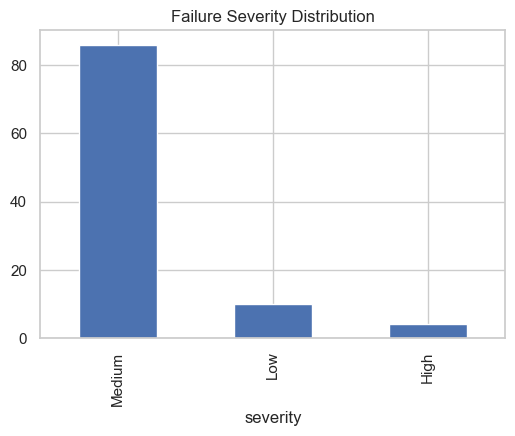

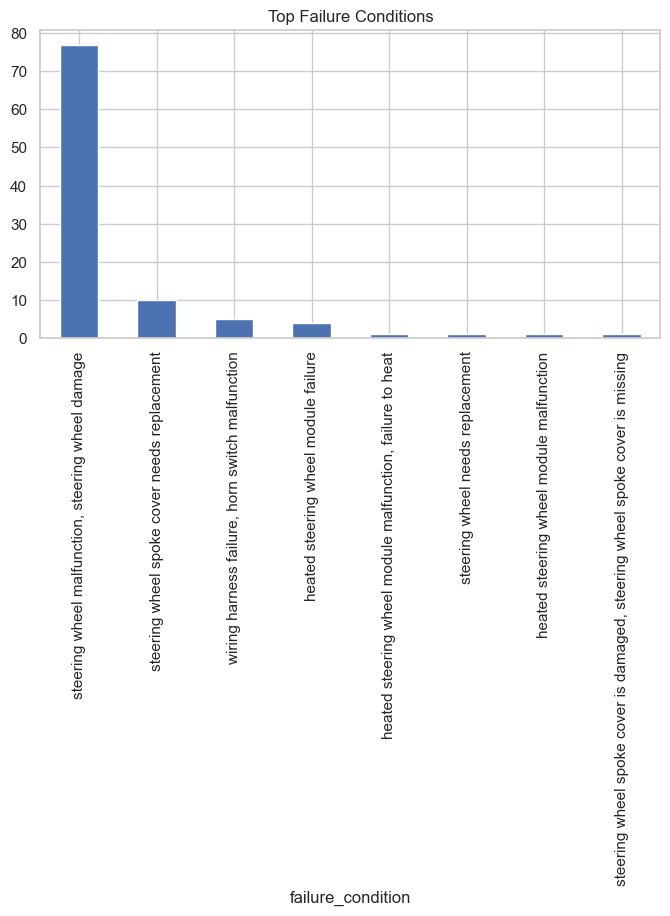

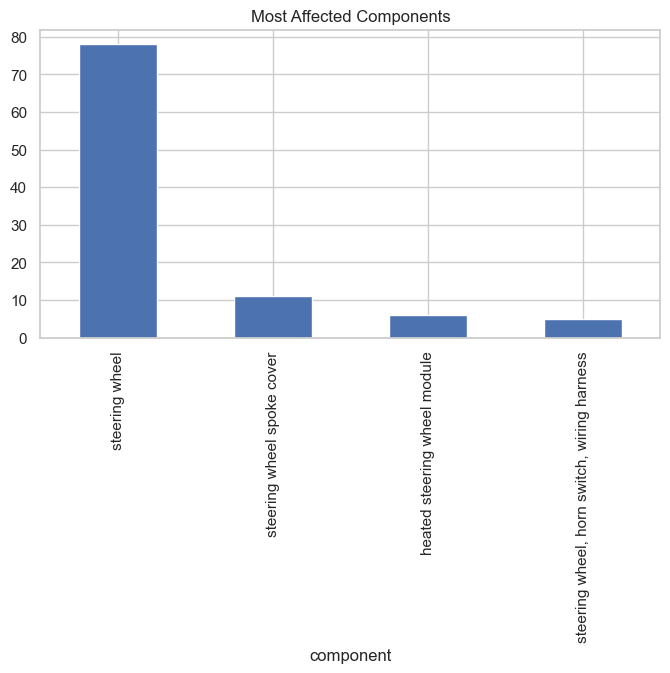

In [10]:
# Severity distribution
plt.figure(figsize=(6,4))
df_clean["severity"].value_counts().plot(kind="bar")
plt.title("Failure Severity Distribution")
plt.show()

# Top failure conditions
plt.figure(figsize=(8,4))
df_clean["failure_condition"].value_counts().head(10).plot(kind="bar")
plt.title("Top Failure Conditions")
plt.show()

# Top components
plt.figure(figsize=(8,4))
df_clean["component"].value_counts().head(10).plot(kind="bar")
plt.title("Most Affected Components")
plt.show()


In [11]:
key_takeaways = pd.DataFrame({
    "Insights": [
        "LLM used for semantic tagging of failure descriptions",
        "Improved detection of failure patterns beyond keywords",
        "Severity and component insights enable better maintenance prioritization",
        "Data cleaned using robust imputation and outlier handling"
    ]
})


In [13]:
output_file = "SA_Task1_LLM_Analysis1.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    df_clean.to_excel(writer, sheet_name="Cleaned_Tagged_Data", index=False)
    summary_df.to_excel(writer, sheet_name="Column_Summary", index=False)
    key_takeaways.to_excel(writer, sheet_name="Key_Takeaways", index=False)

print("Analysis Completed & Saved:", output_file)


Analysis Completed & Saved: SA_Task1_LLM_Analysis1.xlsx
